In [1]:
# import libraries
import torch
import numpy as np
from torch.utils.data import DataLoader, TensorDataset, random_split
import pandas as pd

# read the dataset built for Convolutional Neural Network
df = pd.read_pickle('spin_glass_dataset.pkl')

# extract values to pass to the network
J_list = df['J'].values  
T_list = df['T'].values   
energy_list = df['energy'].values  
q_EA_list = df['q_EA'].values      

# conversion in PyTorch tensors 
J_tensors = torch.stack([torch.tensor(J, dtype=torch.float32) for J in J_list])
T_tensors = torch.tensor(T_list, dtype=torch.float32).unsqueeze(1)
energy_tensors = torch.tensor(energy_list, dtype=torch.float32).unsqueeze(1)
q_EA_tensors = torch.tensor(q_EA_list, dtype=torch.float32).unsqueeze(1)

# concatenation of energy and q_EA 
targets = torch.cat([energy_tensors, q_EA_tensors], dim=1)

J_tensors_tp = torch.swapaxes(J_tensors,2,3)
J_tensors_tp = torch.swapaxes(J_tensors_tp,1,2)

# creation of dataset
dataset = TensorDataset(J_tensors_tp, T_tensors, energy_tensors, q_EA_tensors)


# 
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Creazione dei DataLoader per il training e il validation set
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)



In [2]:
print(J_tensors[0].shape)

torch.Size([6, 6, 4])


In [3]:
print(T_tensors[0].shape)

torch.Size([1])


In [4]:
for i in range(6):
    for j in range(6):
        for k in range(4):
            if J_tensors[0][i][j][k] != J_tensors_tp[0][k][i][j]:
                print(':(')
            else:
                print(':)')

:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)


In [5]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import CosineAnnealingLR

# Definizione del modello CNN
class SpinGlassCNN(nn.Module):
    def __init__(self):
        super(SpinGlassCNN, self).__init__()
        self.conv1 = nn.Conv2d(4, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 6 * 6 + 1, 256)  # +1 per T
        self.fc2_energy = nn.Linear(256, 1)
        self.fc2_qEA = nn.Linear(256, 1)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()

    def forward(self, J, T):
        x = self.relu(self.conv1(J))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.flatten(x)
        #T = T.squeeze(-1)  # toglie una dimensione per il concatenamento
        x = torch.cat([x, T], dim=1)  # Concatena T al vettore
        x = self.relu(self.fc1(x))
        energy = self.fc2_energy(x)
        qEA = self.fc2_qEA(x)
        return energy, qEA

In [10]:
# Imposta il device per la GPU se disponibile
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Inizializza il modello e spostalo su GPU
model = SpinGlassCNN().to(device)

# Calcola il numero totale di parametri allenabili
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Il numero totale di parametri allenabili è: {total_params}")

# Definisci la loss function e l'optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Loop di training
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for J, T, energy, q_EA in train_loader:
        # Sposta i dati su GPU
        J = J.to(device)
        T = T.to(device)
        energy = energy.to(device)
        q_EA = q_EA.to(device)

        # Forward pass
        energy_pred, qEA_pred = model(J, T)

        # Calcola la loss
        loss_energy = criterion(energy_pred, energy)
        loss_qEA = criterion(qEA_pred, q_EA)
        loss = loss_energy + loss_qEA

        # Backward pass e ottimizzazione
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Stampa la loss media per l'epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

    # Validazione
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for J, T, energy, q_EA in val_loader:
            J = J.to(device)
            T = T.to(device)
            energy = energy.to(device)
            q_EA = q_EA.to(device)

            energy_pred, qEA_pred = model(J, T)

            loss_energy = criterion(energy_pred, energy)
            loss_qEA = criterion(qEA_pred, q_EA)
            loss = loss_energy + loss_qEA

            val_loss += loss.item()

    print(f'Validation Loss: {val_loss/len(val_loader):.4f}')

Il numero totale di parametri allenabili è: 1274210
Epoch [1/10], Loss: 64.0163
Validation Loss: 11.9238
Epoch [2/10], Loss: 7.5646
Validation Loss: 7.4160
Epoch [3/10], Loss: 4.2127
Validation Loss: 3.6942
Epoch [4/10], Loss: 3.4506
Validation Loss: 3.0405
Epoch [5/10], Loss: 3.1348
Validation Loss: 3.3095
Epoch [6/10], Loss: 2.8176
Validation Loss: 2.2167
Epoch [7/10], Loss: 2.8392
Validation Loss: 2.1931
Epoch [8/10], Loss: 2.7994
Validation Loss: 2.3646
Epoch [9/10], Loss: 2.4583
Validation Loss: 2.1158
Epoch [10/10], Loss: 2.4652
Validation Loss: 3.4688


In [9]:
from sklearn.metrics import mean_squared_error

model.eval()
test_preds = []
test_targets = []

with torch.no_grad():
    for J, T, energy, q_EA in val_loader:
        J = J.to(device)
        T = T.to(device)
        energy = energy.to(device)
        q_EA = q_EA.to(device)

        # Forward pass
        energy_pred, qEA_pred = model(J, T)

        # Append the predictions and targets
        test_preds.append(torch.cat((energy_pred.cpu(), qEA_pred.cpu()), dim=1).numpy()) # perché numpy funziona solo sulla cpu
        test_targets.append(torch.cat((energy.cpu(), q_EA.cpu()), dim=1).numpy())

test_preds = np.concatenate(test_preds, axis=0)
test_targets = np.concatenate(test_targets, axis=0)

# Calcolo dell'RMSE
rmse_energy = np.sqrt(mean_squared_error(test_targets[:, 0], test_preds[:, 0]))
rmse_q_EA = np.sqrt(mean_squared_error(test_targets[:, 1], test_preds[:, 1]))

print(f"RMSE Energy: {rmse_energy:.4f}")
print(f"RMSE q_EA: {rmse_q_EA:.4f}")


RMSE Energy: 1.4857
RMSE q_EA: 0.1466


In [72]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
import random

In [73]:
def create_initial_config(N=None):
    states = [-1., 1.]
    config = np.random.choice(states, (N, N))
    return config

def metropolis_single_update(config=None, T=None, J=None):
    N, M = config.shape
    assert N == M, "Wrong configuration shape"
    i = np.random.randint(N)
    j = np.random.randint(M)
    s =  config[i, j]
    DeltaE = 2*s*(J[i,j,0]*config[i,(j-1)%N] + J[i,j,1]*config[i,(j+1)%N] + J[i,j,2]*config[(i+1)%N, j] + J[i,j,3]*config[(i-1)%N, j])
    effDeltaE = 0
    if DeltaE < 0:
        s *= -1
        effDeltaE = DeltaE
    else:
        if np.random.random() < np.exp(-DeltaE/T):
            s *= -1
            effDeltaE = DeltaE
    config[i, j] = s
    return effDeltaE

def crea_vettore(N, p):
    dim = (N-1)*N*2
    vettore = np.ones(dim, dtype=int)
    indici_negativi = np.random.choice(dim, p, replace=False)
    vettore[indici_negativi] = -1
    return vettore

def crea_spin_glass_dataset(N, v):
    J = np.zeros((N, N, 4), dtype=int)
    count = 0
    for i in range(N):
        for j in range(N):
            if j == 0:
                J[i, j, 0] = 0
            else:
                J[i, j, 0] = J[i, j-1, 1]
            if j == N-1:
                J[i, j, 1] = 0
            else:
                J[i, j, 1] = v[count]
                count = count + 1
            if i == 0:
                J[i, j, 2] = 0
            else:
                J[i, j, 2] = J[i-1, j, 3]
            if i == N-1:
                J[i, j, 3] = 0
            else:
                J[i, j, 3] = v[count]
                count = count + 1
    return J

def compute_q_EA(config_history):
    N = config_history.shape[1]
    avg_spins = np.mean(config_history, axis=0)
    q_EA = np.sum(avg_spins ** 2) / (N * N)
    return q_EA

def compute_total_energy(config, J):
    N, M = config.shape
    total_energy = 0
    for i in range(N):
        for j in range(M):
            s = config[i, j]
            total_energy -= s * (J[i, j, 0] * config[i, (j-1)%N] +
                                 J[i, j, 1] * config[i, (j+1)%N] +
                                 J[i, j, 2] * config[(i+1)%N, j] +
                                 J[i, j, 3] * config[(i-1)%N, j])
    return total_energy / 2  # To account for double-counting

In [111]:
# Parametri
N = 6
T_values = np.arange(4, 0, -0.1)
T_values = np.append(T_values, 0.1)
n_updates = 100000

# Generazione del dataset di spin glass
p = random.choice(range(0, (N-1) * N * 2 + 1))
v = crea_vettore(N, p)
J = crea_spin_glass_dataset(N, v)

# Inizializzazione della configurazione
config = create_initial_config(N)

In [112]:
mc_energies = []
mc_q_EAs = []
mc_df = []

for T in T_values:
    total_energy_sum = 0
    config_history = []
    total_measurements = 0

    for k in range(n_updates):
        DeltaE = metropolis_single_update(config, T=T, J=J)
        if k > 10000 and k % 100 == 0:
            config_history.append(config.copy())
            total_energy = compute_total_energy(config, J)
            total_energy_sum += total_energy
            total_measurements += 1

    average_energy = total_energy_sum / total_measurements
    config_history = np.array(config_history)
    q_EA = compute_q_EA(config_history)
    # Aggiungi i risultati al vettore di energia e q_EA
    mc_energies.append(average_energy)
    mc_q_EAs.append(q_EA)
    
    # Salva i dati nel dataset
    mc_df.append({
        'J': J,
        'T': T,
        'energy': average_energy,
        'q_EA': q_EA
        })

mc_df = pd.DataFrame(mc_df)  


In [98]:
mc_df = pd.DataFrame(mc_df)  

In [115]:
print(len(mc_df['energy'].values))

41


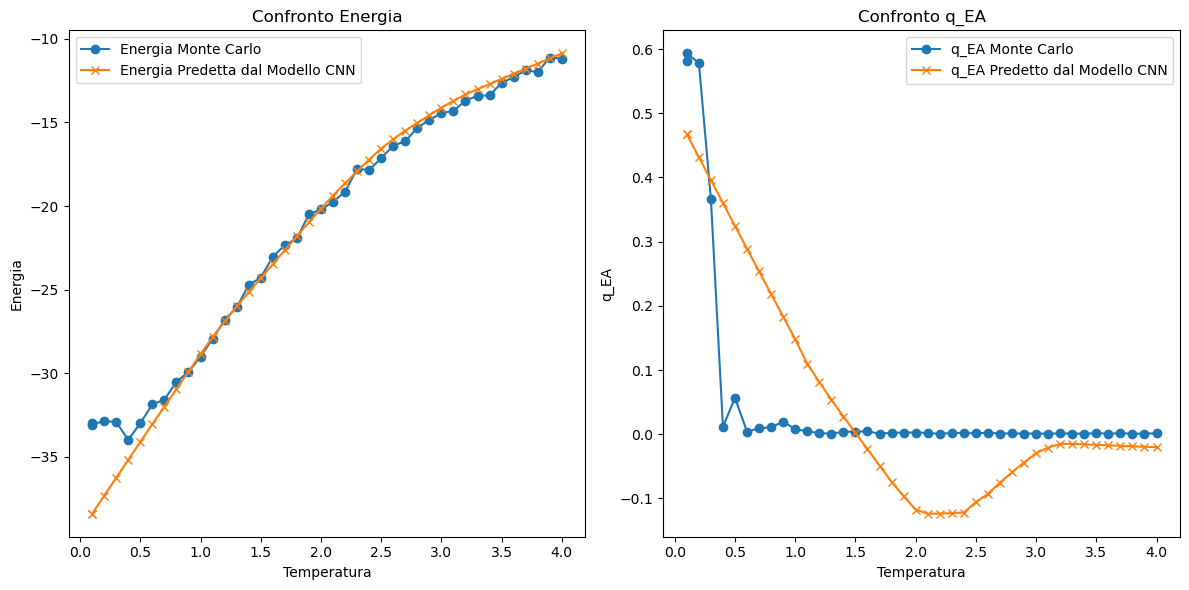

In [116]:
##############################################
# Estrazione delle feature e dei target
J_list1 = mc_df['J'].values  # Lista di matrici 6x6x4
T_list1 = mc_df['T'].values   # Lista di temperature
energy_list1 = mc_df['energy'].values  # Lista di energy
q_EA_list1 = mc_df['q_EA'].values      # Lista di q_EA

# Conversione in tensori PyTorch e pre-elaborazione
J_tensors1 = torch.stack([torch.tensor(J, dtype=torch.float32) for J in J_list1])
T_tensors1 = torch.tensor(T_list1, dtype=torch.float32).unsqueeze(1)
energy_tensors1 = torch.tensor(energy_list1, dtype=torch.float32).unsqueeze(1)
q_EA_tensors1 = torch.tensor(q_EA_list1, dtype=torch.float32).unsqueeze(1)

# Concatenazione di energy e q_EA come target
targets1 = torch.cat([energy_tensors1, q_EA_tensors1], dim=1)

J_tensors_tp1 = torch.swapaxes(J_tensors1,2,3)
J_tensors_tp1 = torch.swapaxes(J_tensors_tp1,1,2)
# Creazione del TensorDataset
dataset1 = TensorDataset(J_tensors_tp1, T_tensors1, energy_tensors1, q_EA_tensors1)
############################################
# Crea un dataset e dataloader per i dati Monte Carlo
#mc_dataset = SpinGlassDataset(mc_df)
mc_loader = DataLoader(dataset1, batch_size=32, shuffle=False)

# Passa i dati al modello e ottieni le previsioni
model.eval()
energy_preds = []
qEA_preds = []

with torch.no_grad():
    for J, T, energy, q_EA in mc_loader:
        # Sposta i dati su GPU
        J = J.to(device)
        T = T.to(device)
        energy = energy.to(device)
        q_EA = q_EA.to(device)

        # Forward pass
        energy_pred, qEA_pred = model(J,T)
        energy_preds.extend(energy_pred.cpu().numpy())
        qEA_preds.extend(qEA_pred.cpu().numpy())

# Converti le previsioni in array numpy
energy_preds = np.array(energy_preds).flatten()
qEA_preds = np.array(qEA_preds).flatten()

import matplotlib.pyplot as plt

# Plot dei risultati Monte Carlo e delle previsioni del modello CNN
plt.figure(figsize=(12, 6))

# Plot per l'energia
plt.subplot(1, 2, 1)
plt.plot(T_list1, mc_energies, label='Energia Monte Carlo', marker='o')
plt.plot(T_list1, energy_preds, label='Energia Predetta dal Modello CNN', marker='x')
plt.xlabel('Temperatura')
plt.ylabel('Energia')
plt.title('Confronto Energia')
plt.legend()

# Plot per q_EA
plt.subplot(1, 2, 2)
plt.plot(T_list1, mc_q_EAs, label='q_EA Monte Carlo', marker='o')
plt.plot(T_list1, qEA_preds, label='q_EA Predetto dal Modello CNN', marker='x')
plt.xlabel('Temperatura')
plt.ylabel('q_EA')
plt.title('Confronto q_EA')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# valida alternativa:

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import CosineAnnealingLR


# Definizione del modello CNN
class SpinGlassCNN(nn.Module):
    def __init__(self):
        super(SpinGlassCNN, self).__init__()
        self.conv1 = nn.Conv2d(4, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(2305, 500) 
        self.fc2 = nn.Linear(500, 250)
        self.fc4_energy = nn.Linear(250, 1)
        self.fc4_qEA = nn.Linear(250, 1)
        self.leaky_relu = nn.LeakyReLU()
        self.flatten = nn.Flatten()

    def forward(self, J, T):
        x = self.leaky_relu(self.conv1(J))
        x = self.leaky_relu(self.conv2(x))
        x = self.leaky_relu(self.conv3(x))
        x = self.flatten(x)
        #T = T.squeeze(-1)  # toglie una dimensione per il concatenamento
        x = torch.cat([x, T], dim=1)  # Concatena T al vettore
        x = self.leaky_relu(self.fc1(x))
        x = self.leaky_relu(self.fc2(x))
        energy = self.fc4_energy(x)
        qEA = self.fc4_qEA(x)
        return energy, qEA